# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [27]:
from sklearn import datasets, model_selection, metrics, tree, linear_model
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
X, y = datasets.load_boston(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=0)

## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

In [4]:
def f_derivative(y_pred, y): 
    return -(y_pred - y)

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [30]:
base_algorithms = [] # массив с базовыми алгоритмами, будем добавлять сюда на каждом шаге новый алгоритм
coefficients = [0.9] * 50 #массив с нормами обучения

# возвращает предсказанные значения
# суммируем все значения, полученные на предыдущих алгоритмах с некоторым коэффициентом
def gbm_predict(X): 
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms, coefficients)]) for x in X]


answers = [y_train.mean()] * len(y_train) # инициализируем первый алгоритм средними значениями

for i in range(50): 
    base_algorithms.append(tree.DecisionTreeRegressor(max_depth=5, random_state=42)) # добавляем алгоритм
    base_algorithms[i].fit(X_train, answers) #обучаем на объектах и ответах (в первый раз это средние значения, дальше - антиградиент функции ошибок)
    y_preds = gbm_predict(X_train)
    answers = f_derivative(y_preds, y_train)
    print(i, metrics.mean_squared_error(y_preds, y_train))




0 90.41977190983029
1 6.883139700352184
2 3.731053650758252
3 2.546052485038209
4 1.8977299956151683
5 1.561591883718383
6 1.3409355527432596
7 0.8804520372419956
8 0.7459896196055704
9 0.6290401477501559
10 0.44593620711677195
11 0.36118432910357917
12 0.3222965867723138
13 0.24911159947950012
14 0.2152152510311992
15 0.16926692991079198
16 0.11219646332628085
17 0.09068348957343701
18 0.07663836747006447
19 0.058512228419905755
20 0.04280219280422263
21 0.033500651972152545
22 0.025686010305125538
23 0.018342454449838803
24 0.015641504616013244
25 0.014899623073842254
26 0.011751928680059955
27 0.009010385102909475
28 0.0062712146092662995
29 0.004671570354053855
30 0.0035096258537422468
31 0.002851242813953211
32 0.002053227022999147
33 0.0018839322276534582
34 0.0017520667973800084
35 0.0013391638535163977
36 0.000977809163240079
37 0.0007832604774197537
38 0.0006468587660162575
39 0.0005009525426706187
40 0.00036309232464720487
41 0.00026629655277547813
42 0.0001689243317548754
43

In [31]:
np.sqrt(metrics.mean_squared_error(gbm_predict(X_test), y_test))

5.166426894718952

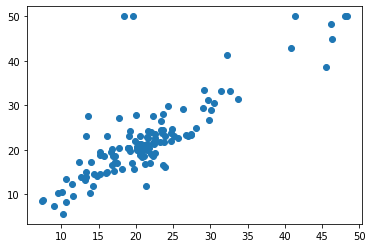

In [23]:
pylab.plot(gbm_predict(X_test), y_test, 'o')

## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [32]:
base_algorithms = []
coefficients = [0.9 / (1 + i) for i in range(50)]
answers = [y_train.mean()] * len(y_train)

for i in range(50): 
    base_algorithms.append(tree.DecisionTreeRegressor(max_depth=5, random_state=42))
    base_algorithms[i].fit(X_train, answers)
    y_preds = gbm_predict(X_train)
    answers = f_derivative(y_preds, y_train)
    print(i, metrics.mean_squared_error(y_train, y_preds))
    

0 90.41977190983029
1 31.564417398607073
2 17.564519068796738
3 11.862048192627656
4 8.78207262863517
5 7.005198301476247
6 5.828863544153835
7 5.0398672438770165
8 4.451149795228167
9 4.004476232784491
10 3.6360552187007733
11 3.33953889112165
12 3.1055655758017022
13 2.9061293878542505
14 2.742626957635481
15 2.6060536601590165
16 2.4894310640324755
17 2.3634470947750317
18 2.2694560308753817
19 2.185835462291486
20 2.09505606898683
21 2.0086232559081023
22 1.9301767629105095
23 1.862598999688213
24 1.8002406497486831
25 1.742734315004897
26 1.6997346790724632
27 1.6543233877024817
28 1.611811281099148
29 1.5811860748482347
30 1.545991958774937
31 1.5183345399532915
32 1.4836026470532189
33 1.461241708883013
34 1.4314623028889881
35 1.406566786576827
36 1.3827828808476144
37 1.3596423775795423
38 1.3368092870304324
39 1.3125551903163781
40 1.293659639162515
41 1.2727898537717843
42 1.2543205878262826
43 1.2347512241640946
44 1.2180690652252806
45 1.2002645228969118
46 1.1852266548861

In [33]:
np.sqrt(metrics.mean_squared_error(gbm_predict(X_test), y_test))

4.174423531675966

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [ ]:
import xgboost as xgb

In [ ]:
xgbreg = xgb.XGBRegressor(random_state=42)
n_trees = np.arange(10, 2000, 20)
depths = np.arange(2, 50, 2)

cv_trees = model_selection.validation_curve(xgbreg, X_train, y_train, param_name='n_estimators', 
                                param_range=n_trees, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

In [ ]:
pylab.plot(n_trees, cv_trees[1].mean(axis=1) * -1)
pylab.ylim(0, 10)

In [ ]:
cv_depths = model_selection.validation_curve(xgbreg, X_train, y_train, param_name='max_depth', 
                                            param_range=depths, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

In [ ]:
pylab.plot(depths, cv_depths[1].mean(axis=1) * -1)

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [38]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)
np.sqrt(metrics.mean_squared_error(y_test, linreg.predict(X_test)))

5.457311159564073